In [36]:
import torch
import torch.nn as nn
from sklearn.datasets import make_circles,make_moons
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [37]:
class LinearClassifier(nn.Module):
    def __init__(self, in_dimension: int):
        super().__init__()
        self.in_dimension=in_dimension
        self.linear=nn.Linear(in_dimension,1)
        self.sigmoid=nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.sigmoid(self.linear(x))

In [38]:
def linear_dataset(n_per_class=250):
    x1_points=np.linspace(-1,1,n_per_class)
    x=np.zeros((2*n_per_class,2))
    y=np.zeros(2*n_per_class)

    for k in range(n_per_class):
        sf_x=np.random.randint(2,10)
        sf_y=np.random.choice(np.arange(2,4))
        x[2*k,:]=[x1_points[k]+(2*np.random.random()-1)/sf_x,0.5+(2*np.random.random()-1)/sf_y]
        x[2*k+1,:]=[x1_points[k]+(2*np.random.random()-1)/sf_x,-0.5+(2*np.random.random()-1)/sf_y]
        y[2*k+1]=1

    for k in range(x.shape[0]):
        if y[k]==1:
            x[k,1]=(x[k,1]-1)/2
        else:
            x[k,1]=(x[k,1]+1)/2
    return x,y,'Linear Dataset'

def vee_dataset(n_per_class=250):
    x_points=np.linspace(-1,1,n_per_class)

    x=np.zeros((2*n_per_class,2))
    y=np.zeros(2*n_per_class)

    for k in range(n_per_class):
        x[2*k,:]=[x_points[k]+(2*np.random.random()-1)/10,np.abs(x_points[k]+(2*np.random.random()-1)/10)]
        x[2*k+1,:]=[x_points[k]+(2*np.random.random()-1)/10,np.abs(x_points[k]+(2*np.random.random()-1)/10)+0.5]
        y[2*k+1]=1
    return x,y,'Vee-Shaped Dataset'

def circles_dataset(n_per_class=250):
    data=make_circles(2*n_per_class,noise=0.05,factor=0.5)
    x=data[0]
    y=data[1]
    return x,y,'Circles Dataset'

def curved_dataset(n_per_class=250):
    data=make_moons(2*n_per_class,noise=0.1)
    x=data[0]
    y=data[1]
    return x,y,'Curved Dataset'

In [39]:
x,y,dataset_name=curved_dataset()

x1_mean=np.mean(x[:,0])
x1_max=np.max(np.abs(x[:,0]))
x2_mean=np.mean(x[:,1])
x2_max=np.max(np.abs(x[:,1]))
x_max=max(x1_max,x2_max)
for k in range(x.shape[0]):
    x[k,:]=(x[k,:]-np.array([x1_mean,x2_mean]))/x_max

x=torch.tensor(x).float()
y=torch.tensor(y).float().unsqueeze(1)

In [40]:
num_epochs=100
batch_size=16
lr=1e-2
dataset_size=x.shape[0]

model=LinearClassifier(2)
opt=torch.optim.Adam(model.parameters(),lr=lr)
criterion=nn.BCELoss()

In [41]:
progress_bar=tqdm(range(num_epochs))
for epoch in progress_bar:
    epoch_cycles=dataset_size//batch_size
    epoch_loss=0
    for cycle in range(epoch_cycles+1):
        if cycle==epoch_cycles:
            inputs=x[-cycle*batch_size:,:]
            targets=y[-cycle*batch_size:]
        else:
            inputs=x[cycle*batch_size:(cycle+1)*batch_size,:]
            targets=y[cycle*batch_size:(cycle+1)*batch_size]
        opt.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,targets)
        loss.backward()
        opt.step()
        epoch_loss+=loss*len(targets)
    progress_bar.set_description(f'Epoch {epoch+1}/{num_epochs}: loss={epoch_loss/dataset_size:.4f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 100/100: loss=0.4943: 100%|██████████| 100/100 [00:06<00:00, 14.46it/s]


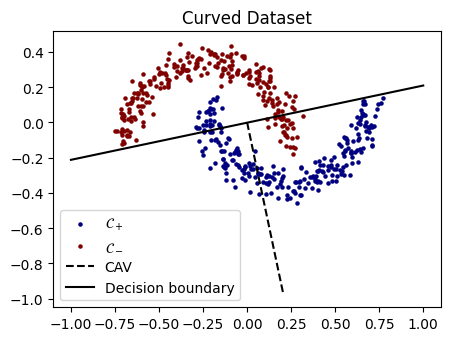

In [42]:
fig,ax=plt.subplots(nrows=1,ncols=1)
ax.set_aspect('equal')
fig.set_figwidth(5)
fig.set_figheight(5)
cav=model.linear.weight.detach()[0]
cav_norm=torch.norm(cav,p=2).item()
cav=cav/cav_norm
bias=model.linear.bias.detach()

colors = plt.cm.jet(np.linspace(0,1,2))

ax.scatter(x=x[(y.T)[0]==1,0],y=x[(y.T)[0]==1,1],color=colors[0],label='$\\mathcal{C}_+$',s=5)
ax.scatter(x=x[(y.T)[0]==0,0],y=x[(y.T)[0]==0,1],color=colors[1],label='$\\mathcal{C}_-$',s=5)
ax.plot([0,cav[0]],[0,cav[1]],'--',color='black',label='CAV')
xs=np.linspace(-1,1,100)
ys=(-bias/cav_norm-cav[0].item()*xs)/cav[1].item()
plotting_points=(ys>min(x[:,1]))&(ys<max(x[:,1]))
ax.plot(xs[plotting_points],ys[plotting_points],color='black',label='Decision boundary')
ax.legend()
ax.set_title(dataset_name)
plt.show()

In [50]:
num_iterations=10

dataset_shapes=['linear','curved','vee','circles']
progress_bar=tqdm(enumerate(dataset_shapes),total=len(dataset_shapes))
colors = plt.cm.jet(np.linspace(0,1,len(dataset_shapes)))

norms_between_cavs={dataset:[] for dataset in dataset_shapes}

for p,dataset in progress_bar:
    if dataset=='linear':
        x,y,dataset_name=linear_dataset()
    elif dataset=='curved':
        x,y,dataset_name=curved_dataset()
    elif dataset=='vee':
        x,y,dataset_name=vee_dataset()
    else:
        x,y,dataset_name=circles_dataset()
    x=torch.tensor(x).float()
    y=torch.tensor(y).float().unsqueeze(1)

    dataset_size=x.shape[0]
    cavs=[]
    for n in range(num_iterations):
        model=LinearClassifier(2)
        opt=torch.optim.Adam(model.parameters(),lr=lr)
        criterion=nn.BCELoss()

        permutation=torch.randperm(x.shape[0])
        x=x[permutation,:]
        y=y[permutation]

        for epoch in range(num_epochs):
            epoch_cycles=dataset_size//batch_size
            epoch_loss=0
            for cycle in range(epoch_cycles+1):
                if cycle==epoch_cycles:
                    inputs=x[-cycle*batch_size:,:]
                    targets=y[-cycle*batch_size:]
                else:
                    inputs=x[cycle*batch_size:(cycle+1)*batch_size,:]
                    targets=y[cycle*batch_size:(cycle+1)*batch_size]
                opt.zero_grad()
                outputs=model(inputs)
                loss=criterion(outputs,targets)
                loss.backward()
                opt.step()
                epoch_loss+=loss*len(targets)
        progress_bar.set_description(f'{dataset} {n+1}/{num_iterations} loss={epoch_loss/dataset_size:.4f}')
                
        cav=model.linear.weight.detach()[0]
        cav=cav/torch.norm(cav)
        cavs.append(cav)

    for k in range(len(cavs)):
        for l in range(len(cavs)):
            if k==l:
                continue
            norms_between_cavs[dataset].append(torch.norm(cavs[k]-cavs[l]).item())

  0%|          | 0/4 [00:00<?, ?it/s]

circles 10/10 loss=1.3759: 100%|██████████| 4/4 [02:43<00:00, 40.95s/it]


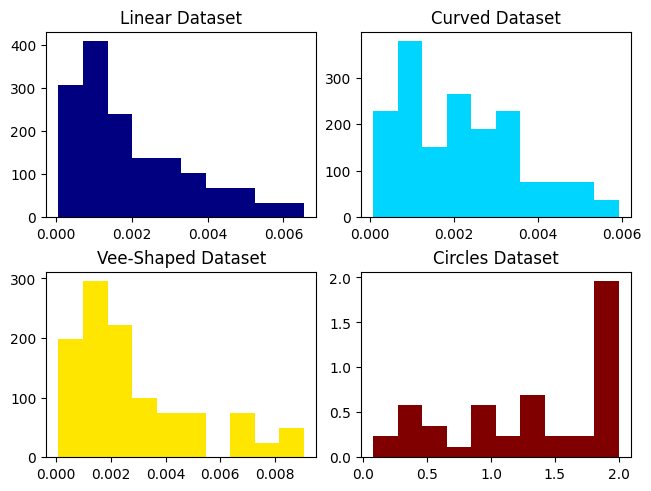

In [58]:
formatted_dataset_names=['Linear Dataset','Curved Dataset','Vee-Shaped Dataset','Circles Dataset']
colors = plt.cm.jet(np.linspace(0,1,4))

fig,axs=plt.subplots(nrows=2,ncols=2,layout='constrained')
axs_flatten=axs.flatten()
for n,(dataset,cav_norms) in enumerate(norms_between_cavs.items()):
    axs_flatten[n].hist(cav_norms,color=colors[n],density=True)
    axs_flatten[n].set_title(formatted_dataset_names[n])
plt.show()